In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

In [2]:
# Euler integration timescale
tmax = 1000 # ms
dt = 1
steps = int(tmax/dt)
ts = np.arange(steps)

# synaptic weights
w23 = np.array([1, -1], dtype='float64')
w12 = np.array([1, -1, 1, -1], dtype='float64')

In [3]:
def show_responses(y1, y2, y3):
    plt.rcParams.update({'font.size': 18})
    fig, axes = plt.subplots(3, 1)
    fig.set_size_inches(10, 10)
    fig.tight_layout()
    for i, c in enumerate(('blue', 'green', 'red', 'cyan')):
        axes[2].plot(ts*dt, y1[i], color=c)

    for i, c in enumerate(('purple', 'orange')):
        axes[1].plot(ts*dt, y2[i], color=c)

    axes[0].plot(ts*dt, y3, color='grey')

    axes[2].set_title('Layer 1')
    axes[1].set_title('Layer 2')
    axes[0].set_title('Layer 3')
    axes[0].set_ylabel('Response')
    axes[2].set_xlabel('Time (ms)')

In [4]:
def sim(sensory, prior, a, l, add_noise=False):
    y1 = np.zeros([4, steps], dtype='float64')
    y2 = np.zeros([2, steps], dtype='float64')
    y3 = np.zeros(steps, dtype='float64')
    v2 = np.zeros(2, dtype='float64')
    
    y1[:, 0] = np.random.random(4) / 10
    y2[:, 0] = np.random.random(2) / 10
    y3[0] = np.random.random(1) / 10
    noise = 0
    
    for t in ts[1:]:
        if add_noise:
            noise = np.random.normal(0, np.cos(2 * np.pi * t * 10)/10 + 0.1)
            #noise += dt * (- 1 / 10 * noise + w)
            
        v3 = y2[:, t-1] @ w23 # weighted sum of the input to layer 3
        
        # layer 1
        for (i,), s in np.ndenumerate(sensory):
            f = y1[i, t-1] - s**2 # feedforward
            
            k = i // 2
            # weighted sum of the input to layer 2
            v2[k] = y1[k*2:(k+1)*2, t-1] @ w12[k*2:(k+1)*2]
            b = (y2[k, t-1] - v2[k]**2) * v2[k] * w12[i] # feedback
            
            y1[i, t] = noise + y1[i, t-1] + dt / tau * \
                (-2 * a[0] * l[0] * f + 4 * a[1] * l[1] * b)
            
            # clip responses
            if y1[i, t] < 0: y1[i, t] = 0
            elif y1[i, t] > 1: y1[i, t] = 1
        
        # layer 2
        for i in range(2):
            f = y2[i, t-1] - v2[i]**2 # feedforward
            
            b = (y3[t-1] - v3**2) * v3 * w23[i] # feedback
            
            y2[i, t] = noise + y2[i, t-1] + dt / tau * \
                (-2 * a[1] * l[1] * f + 4 * a[2] * l[2] * b)
            
            # clip responses
            if y2[i, t] < 0: y2[i, t] = 0
            elif y2[i, t] > 1: y2[i, t] = 1
            
        # layer 3
        f = y3[t-1] - v3**2 # feedforward
        p = y3[t-1] - prior # prior
        
        y3[t] = noise + y3[t-1] + dt / tau * \
            (-2 * a[2] * l[2] * f - 2 * a[2] * (1 - l[2]) * p)
        
        # clip responses
        if y3[t] < 0: y3[t] = 0
        if y3[t] > 1: y3[t] = 1
    return y1, y2, y3

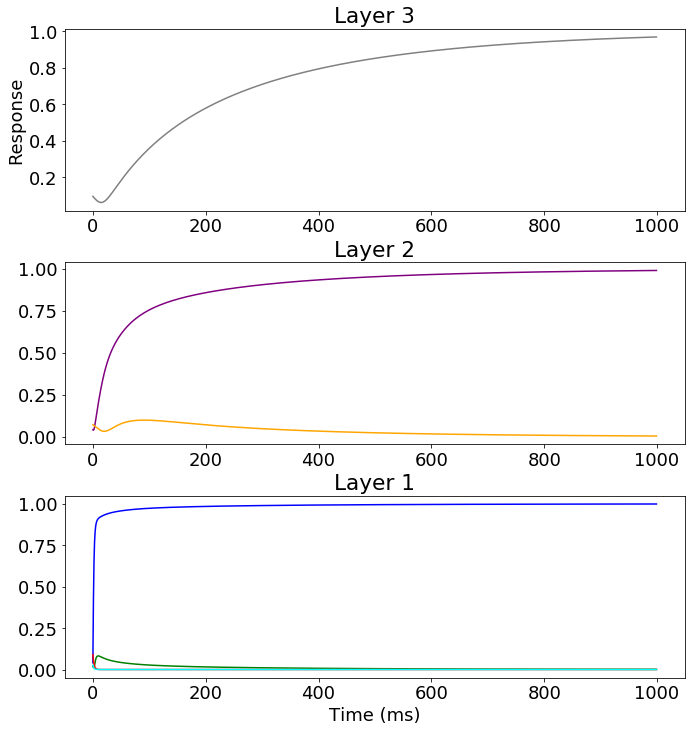

In [5]:
# external drives
sensory = np.array([1, 0, 0, 0], dtype='float64')
prior = 0

# time factor
tau = 5

show_responses(*sim(sensory, prior, (1, 0.1, 0.1), (1, 1, 1)))

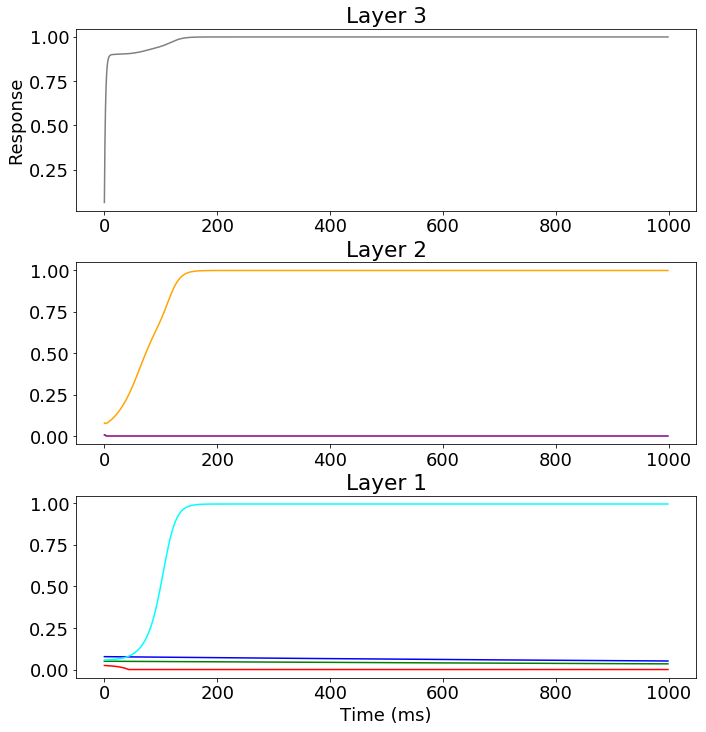

In [6]:
# external drives
sensory = np.array([0, 0, 0, 0], dtype='float64')
prior = 1.0

# time factor
tau = 5

show_responses(*sim(sensory, prior, (0.001, 0.1, 1), (1, 1, 0.1)))

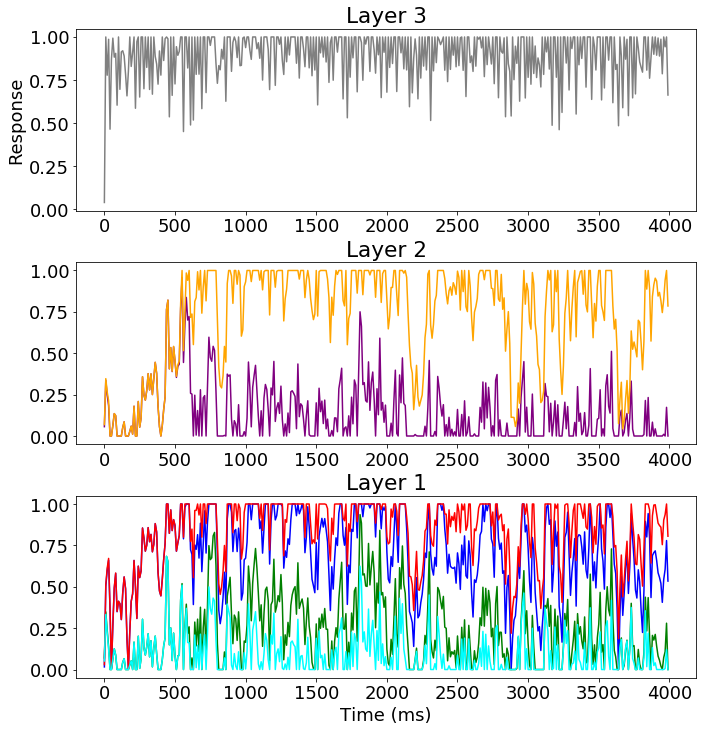

In [7]:
# Euler integration timescale
tmax = 4000 # ms
dt = 10
steps = int(tmax/dt)
ts = np.arange(steps)

# external drives
sensory = np.array([1, 0, 1, 0], dtype='float64')
prior = 1

# time factor
tau = 10

show_responses(*sim(sensory, prior, (0.1, 0.1, 1), (1, 1, 0.1), True))